## TP53 Exploratory Notebook: Ovarian Cancer

In [1]:
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import CPTAC.Ovarian as ov

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Ovarian CPTAC data:
Loading somatic_19 data...
Loading clinical data...
Loading cnv data...
Loading proteomics data...
Loading transcriptomics data...
Loading somatic_38 data...
Loading phosphoproteomics data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until June 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


### Set up initial dataframes and variables

In [2]:
gene='TP53'
somatic = ov.get_somatic_mutations()
proteomics = ov.get_proteomics()
phos = ov.get_phosphoproteomics()
transcriptomics = ov.get_transcriptomics()
# A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.R248L','p.R248Q','p.R248W','p.C275Y','p.K132N','p.R273C','p.R273H','p.R282W','p.V274A',
                     'p.M237I','p.R156P','p.R175H','p.G245D','p.G245S','p.C238F','p.C238Y']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations))]
mutated_hotspot = mutated_hotspot.loc[(mutated_hotspot['Gene'] == gene)]

# Get a list of patient identifiers for those who have mutations in the hotspot
hotspot_patients = mutated_hotspot.index
hotspot_patients

Index(['01OV018', '02OV032', '04OV004', '04OV012', '04OV018', '04OV037',
       '04OV045', '04OV048', '04OV050', '04OV053', '14OV011', '15OV001',
       '17OV010', '17OV010', '17OV017', '17OV025', '17OV027', '17OV030',
       '17OV039', '17OV040', '18OV001', '20OV005', '26OV009', '26OV011',
       '26OV013'],
      dtype='object', name='Patient_Id')

All TP53 mutation effect on NOL10: 0.3552508112627425
Hotspot TP53 mutation effect on NOL10: 0.564228194485892
Non-hotspot TP53 mutation effect on NOL10: 0.2787088525649263
Non-hotspot TP53 mutations vs hotspot TP53 mutations effect on NOL10: 0.717555328749141


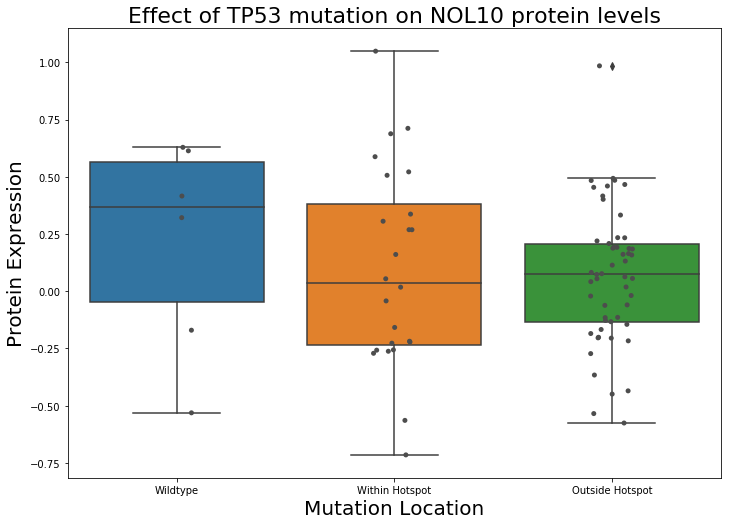

In [28]:
gene = 'TP53'
protein = 'NOL10'
p53_mutations_protein = ov.compare_mutations(proteomics, protein, gene)
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)

#3.  now make two new DFs, one for people with a hotspot mutation, one for all the wildtype cancer patients.
allmutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
mutatedhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Within Hotspot']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
nonhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']

ttestall = scipy.stats.ttest_ind(allmutated[protein], wt[protein])
ttesthtspt = scipy.stats.ttest_ind(mutatedhtspt[protein], wt[protein])
ttest_non_htspt = scipy.stats.ttest_ind(nonhtspt[protein], wt[protein])
ttest_htspt_non_htspt = scipy.stats.ttest_ind(mutatedhtspt[protein], nonhtspt[protein])
print("All TP53 mutation effect on " + protein + ": " + str(ttestall[1]))
print("Hotspot TP53 mutation effect on " + protein + ": " + str(ttesthtspt[1]))
print("Non-hotspot TP53 mutation effect on " + protein + ": " + str(ttest_non_htspt[1]))
print("Non-hotspot TP53 mutations vs hotspot TP53 mutations effect on " + protein + ": " + str(ttest_htspt_non_htspt[1]))
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " protein levels", fontsize='22')
plt.show()

TP53 proteomics missense mutation vs wildtype: 3.4378735570965783e-07
TP53 proteomics truncating mutation vs wildtype: 1.6108520369753996e-05
TP53 proteomics all mutation vs wildtype: 0.1352458289003623


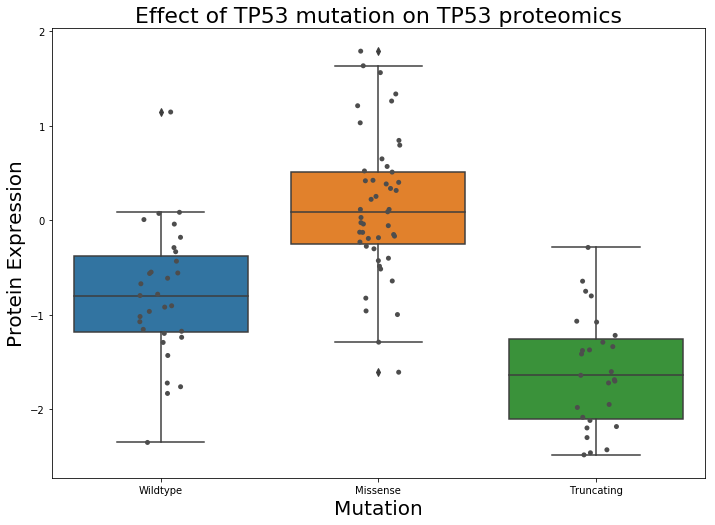

In [6]:
gene = 'TP53'
protein = 'TP53'
# 1.  Merge the mutation status of P53 and the proteomics data of P53
p53_mutations_protein = ov.compare_mutations(proteomics, gene, protein)

# 2. Classify patients into one of 3 categories: wildtype, missense, truncation
p53_mutations_protein = p53_mutations_protein.replace({'Mutation': {'Frame_Shift_Del': 'Truncating',
                                      'Frame_Shift_Ins': 'Truncating',
                                      'Nonsense_Mutation': 'Truncating',
                                      'Splice_Site': 'Truncating',
                                      'Missense_Mutation': 'Missense'}})

# 3.  Make two new DFs, one for people with a mutation, one for all the wildtype cancer patients.
p53_missense = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Missense']
p53_truncating = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Truncating']
p53_mutated = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] != 'Wildtype']
p53_wt = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype']

# 4. ttest for proteomics of TP53 between wildtype cancer and missense mutation
ttest = scipy.stats.ttest_ind(p53_missense[protein], p53_wt[protein])
print(protein + " proteomics missense mutation vs wildtype: " + str(ttest[1]))

# 4. ttest for proteomics of TP53 between wildtype cancer and truncating mutation
ttest = scipy.stats.ttest_ind(p53_truncating[protein], p53_wt[protein])
print(protein + " proteomics truncating mutation vs wildtype: " + str(ttest[1]))

# 4. ttest for proteomics of TP53 between wildtype cancer and all mutation
ttest = scipy.stats.ttest_ind(p53_mutated[protein], p53_wt[protein])
print(protein + " proteomics all mutation vs wildtype: " + str(ttest[1]))

# 5. Plot the data
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Mutation', y = protein, ax = ax, order = ['Wildtype', 'Missense', 'Truncating'])
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Mutation', y = protein, jitter = True, color = '.3', order = ['Wildtype', 'Missense', 'Truncating'])
boxplt.set_xlabel('Mutation', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " proteomics", fontsize='22')
plt.show()

XRN2 proteomics missense mutation vs wildtype: 1.5233137786412131e-06
XRN2 proteomics truncating mutation vs wildtype: 0.044266248071166955
XRN2 proteomics all mutation vs wildtype: 4.794430764998915e-05


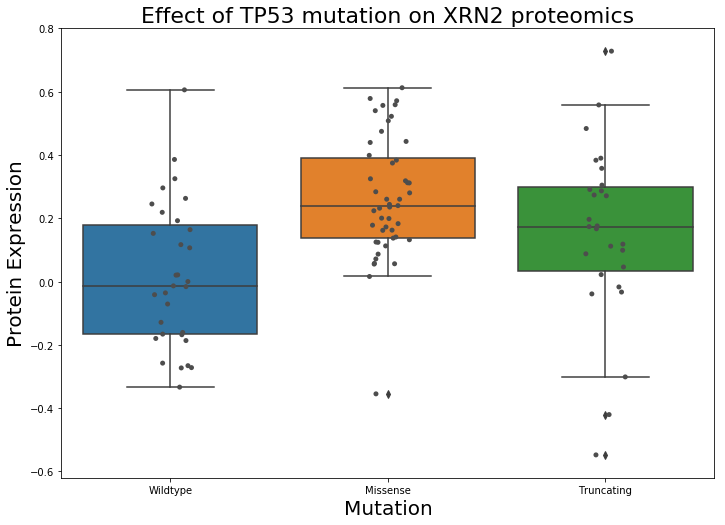

In [13]:
gene = 'TP53'
protein = 'XRN2'
# 1.  Merge the mutation status of P53 and the proteomics data of P53
p53_mutations_protein = ov.compare_mutations(proteomics, protein, gene)

# 2. Classify patients into one of 3 categories: wildtype, missense, truncation
p53_mutations_protein = p53_mutations_protein.replace({'Mutation': {'Frame_Shift_Del': 'Truncating',
                                      'Frame_Shift_Ins': 'Truncating',
                                      'Nonsense_Mutation': 'Truncating',
                                      'Splice_Site': 'Truncating',
                                      'Missense_Mutation': 'Missense'}}).dropna(axis=0)

# 3.  Make two new DFs, one for people with a mutation, one for all the wildtype cancer patients.
p53_missense = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Missense']
p53_truncating = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Truncating']
p53_mutated = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] != 'Wildtype']
p53_wt = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype']

# 4. ttest for proteomics of TP53 between wildtype cancer and missense mutation
ttest = scipy.stats.ttest_ind(p53_missense[protein], p53_wt[protein])
print(protein + " proteomics missense mutation vs wildtype: " + str(ttest[1]))

# 4. ttest for proteomics of TP53 between wildtype cancer and truncating mutation
ttest = scipy.stats.ttest_ind(p53_truncating[protein], p53_wt[protein])
print(protein + " proteomics truncating mutation vs wildtype: " + str(ttest[1]))

# 4. ttest for proteomics of TP53 between wildtype cancer and all mutation
ttest = scipy.stats.ttest_ind(p53_mutated[protein], p53_wt[protein])
print(protein + " proteomics all mutation vs wildtype: " + str(ttest[1]))

# 5. Plot the data
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Mutation', y = protein, ax = ax, order = ['Wildtype', 'Missense', 'Truncating'])
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Mutation', y = protein, jitter = True, color = '.3', order = ['Wildtype', 'Missense', 'Truncating'])
boxplt.set_xlabel('Mutation', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " proteomics", fontsize='22')
plt.show()

## All mutations vs. cancer wildtype

In [107]:
significant_all_mut_wt = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(proteomics.columns)

# Go through every protein in our proteomics dataframe
for protein in proteomics.columns:
    if (protein != 'patient_key'):
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = ov.compare_mutations(proteomics, protein, gene).dropna(axis = 0)
        # Perform the ttest if there is enough data for that protein
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] != 'Wildtype']
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype']
        if len(mutated_tp53) < 2: continue
        if len(wt_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        # Print significant values
        if(len(p53_mutations_protein.columns) > 3):
            if ttest[1][1] <= pcutoff:
                significant_all_mut_wt[protein] = ttest[1]  
        else:
            if ttest[1] <= pcutoff:
                significant_all_mut_wt[protein] = ttest[1]
            
significant_all_mut_wt

{'AGT': 1.7789346374868616e-06,
 'ASPA': 1.1267617262642094e-08,
 'BCHE': 3.7485125530254065e-11,
 'BTD': 1.0263196670049749e-07,
 'DDB2': 1.4842827885718476e-08,
 'EPB42': 2.053663195273451e-07,
 'F13A1': 1.6788286890656644e-06,
 'GALT': 1.5381552690481827e-09,
 'SERPIND1': 5.626927747645359e-07,
 'ITGA6': array([1.68228069e-06, 1.57735194e-06]),
 'LCAT': 6.730499772199816e-09,
 'SGCB': 8.854363235128135e-07,
 'MAOA': 7.909521350456247e-07,
 'NME1': 4.667455834980026e-09,
 'PGK1': 9.717299608859717e-07,
 'PROC': 1.9831086759215955e-06,
 'SGCD': 6.702588599995614e-07,
 'SERPINA7': 6.585189473000617e-08,
 'TIMP3': 7.86473896658748e-09,
 'TPM1': array([1.15667123e-06, 5.43507816e-07, 1.85340769e-08, 9.21479860e-09]),
 'LAMA2': 2.8200240659188093e-10,
 'PECAM1': 3.606213986406801e-07,
 'ALB': 2.0370306525332762e-06,
 'APOA4': 3.5395356568925744e-06,
 'COL4A5': 2.6372091491818194e-06,
 'ELN': array([1.53193681e-06, 1.69316808e-06, 8.50602718e-07]),
 'F10': 3.2971953024075e-06,
 'MPZ': 1.14

## Missense mutations vs. cancer wildtype

In [104]:
significant_missense_wt = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(proteomics.columns)

# Go through every protein in our proteomics dataframe
for protein in proteomics.columns:
    if (protein != 'patient_key'):
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = ov.compare_mutations(proteomics, protein, gene).dropna(axis = 0)
        # Some proteins have duplicate measurements; create a new dataframe with the mean of these measurements
        if len(p53_mutations_protein.columns) > 3:
            prot_data = p53_mutations_protein[protein]
            prot_data[protein+'_mean'] = prot_data.mean(axis=1)
            newdf = pd.DataFrame()
            newdf['Mutation'] = p53_mutations_protein['Mutation']
            newdf[protein] = prot_data[protein+'_mean']
            p53_mutations_protein = newdf
        # Classify mutations into missense, truncating, wildtype
        p53_mutations_protein = p53_mutations_protein.replace({'Mutation': {'Frame_Shift_Del': 'Truncating',
                                      'Frame_Shift_Ins': 'Truncating',
                                      'Nonsense_Mutation': 'Truncating',
                                      'Splice_Site': 'Truncating',
                                      'Missense_Mutation': 'Missense'}})
        # Perform the ttest if there is enough data for that protein
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Missense']
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype']
        if len(mutated_tp53) < 2: continue
        if len(wt_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_missense_wt[protein] = ttest[1]
            
significant_missense_wt

{'ASPA': 3.7173760243171395e-07,
 'BCHE': 7.962566501451592e-08,
 'BTD': 2.6736453996936905e-06,
 'DDB2': 3.4568603277033647e-07,
 'GALT': 3.813527601797108e-07,
 'ITGA6': 5.177495398467907e-07,
 'LCAT': 2.300698744930265e-06,
 'MAOA': 3.635291804572175e-06,
 'NME1': 3.261867952336961e-07,
 'SMN1': 4.469713708642181e-06,
 'TIMP3': 7.842341375571573e-07,
 'LAMA2': 6.937323517485648e-08,
 'TP53': 3.4378735570965783e-07,
 'ADH5': 4.591706232692903e-06,
 'ALDH1A1': 5.693576104362483e-08,
 'ACE': 2.993658227853736e-06,
 'MAOB': 1.403063377040032e-07,
 'PLCB3': 7.098657826577429e-09,
 'RPL4': 2.658476959551383e-06,
 'RPL7': 7.820667428010048e-11,
 'RPL11': 2.3202643308605405e-08,
 'RPL18': 2.1997138952295832e-08,
 'RPL37': 4.941254113232027e-07,
 'RPLP0': 3.474123752117268e-06,
 'RPLP2': 7.70784421057606e-08,
 'RPS4X': 6.125248264367139e-07,
 'RPS5': 6.811273360665475e-09,
 'TOMM5': 5.810810365798772e-08,
 'HNRNPD': 1.2560086422722645e-06,
 'CHD3': 1.413838622535353e-06,
 'RPS11': 4.31626800

In [108]:
only_missense = {k:v for k,v in significant_missense_wt.items() if k not in significant_all_mut_wt}
only_missense

{'SMN1': 4.469713708642181e-06,
 'TP53': 3.4378735570965783e-07,
 'ADH5': 4.591706232692903e-06,
 'DST': 1.0533664684196617e-06,
 'CLINT1': 3.828815141597257e-06,
 'FKBP4': 3.0214102927684914e-06,
 'PDIA4': 2.09151037100321e-06,
 'MANF': 3.5684001112669256e-06,
 'PPP2R5A': 1.7166140483560509e-06,
 'DIAPH2': 2.246434748499047e-06,
 'STRAP': 1.8679088227578254e-07,
 'DDX20': 1.557488054358106e-06,
 'XRN2': 1.5233137786412131e-06}

## Missense mutations vs. truncating mutations

In [112]:
significant_missense_truncating = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(proteomics.columns)

# Go through every protein in our proteomics dataframe
for protein in proteomics.columns:
    if (protein != 'patient_key'):
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = ov.compare_mutations(proteomics, protein, gene).dropna(axis = 0)
        # Some proteins have duplicate measurements; create a new dataframe with the mean of these measurements
        if len(p53_mutations_protein.columns) > 3:
            prot_data = p53_mutations_protein[protein]
            prot_data[protein+'_mean'] = prot_data.mean(axis=1)
            newdf = pd.DataFrame()
            newdf['Mutation'] = p53_mutations_protein['Mutation']
            newdf[protein] = prot_data[protein+'_mean']
            p53_mutations_protein = newdf
        # Classify mutations into missense, truncating, wildtype
        p53_mutations_protein = p53_mutations_protein.replace({'Mutation': {'Frame_Shift_Del': 'Truncating',
                                      'Frame_Shift_Ins': 'Truncating',
                                      'Nonsense_Mutation': 'Truncating',
                                      'Splice_Site': 'Truncating',
                                      'Missense_Mutation': 'Missense'}})
        # Perform the ttest if there is enough data for that protein
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Missense']
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Truncating']
        if len(mutated_tp53) < 2: continue
        if len(wt_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_missense_truncating[protein] = ttest[1]
            
significant_missense_truncating

{'TP53': 5.023711174709319e-16}